In [1]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
import DataProvider

### Build LSTM model

In [66]:
def build_model(max_features_num, maxlen):
    """Build LSTM model"""
    model = Sequential()
    model.add(Embedding(max_features_num, 128, input_length=maxlen))
    model.add(LSTM(128))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['binary_crossentropy','acc'])

    return model

### Load data

In [5]:
benigns, dgas = DataProvider.get_domains_data()
X = benigns + dgas

In [24]:
# Generate a dictionary of valid characters
unique_chars = enumerate(set(''.join(X))) 
chars_dict = dict()
for i, x in unique_chars: #index of enum starts with 0
    #print('i: ' + str(i) + '  x: ' + x)
    chars_dict[x] = i + 1 #leave 0 for padding

In [25]:
#index 0 is also going to be a feature(padding/unknown).
max_features_num = len(chars_dict) + 1

#max length will be the max length of domain in our dataset
maxlen = np.max([len(x) for x in X])

In [26]:
# Convert characters to int
X_in_int = []
for domain in X:
    domain_in_int = []
    for c in domain:
        domain_in_int.append(chars_dict[c])
    X_in_int.append(domain_in_int)

In [27]:
X_in_int[1]

[23, 10, 1, 11, 1, 33, 22, 17, 26, 10, 3]

In [28]:
X[1]

'youtube.com'

In [29]:
#update X
X = X_in_int

In [30]:
#pad to max length
X = sequence.pad_sequences(X, maxlen=maxlen)

In [31]:
#Generate corresponding Y, 0 for 'benign'; 1 for 'dga'
Y = np.hstack([np.zeros(len(benigns)),np.ones(len(dgas))])

### Train the model
Beacuse of the huge size of data, we decided to resample to get a smaller set for training.

Because of the size of benigns domains is 1M, the cut point will be the index of the last benigns domain, which will be:

In [38]:
pos_neg_cutpoint = len(benigns)
print("The cut point will be "+ str(pos_neg_cutpoint))

The cut point will be 1000000


Now, randomly select the same amount of domains from both benigns and dgas.

In [36]:
import random

In [48]:
#set new sampling szie as 50K
sampling_size = 50000

pos_indices = random.sample(range(pos_neg_cutpoint),sampling_size)
neg_indices = random.sample(range(pos_neg_cutpoint, len(X)),sampling_size)

In [51]:
new_X = X[pos_indices + neg_indices]
new_Y = Y[pos_indices + neg_indices]

In [52]:
len(new_X)

100000

#### Fit the model

In [4]:
#training parameters

max_epoch=25
nfolds=10
batch_size=128

In [54]:
#call backs
from keras.callbacks import EarlyStopping
cb = []

cb.append(EarlyStopping(monitor='val_loss', 
                        min_delta=0, #an absolute change of less than min_delta, will count as no improvement
                        patience=2, #number of epochs with no improvement after which training will be stopped
                        verbose=0, 
                        mode='auto', 
                        baseline=None, 
                        restore_best_weights=False))

In [67]:
model = build_model(max_features_num, maxlen)
history = model.fit(x=new_X, y=new_Y, 
                    batch_size=batch_size, 
                    epochs=max_epoch, 
                    verbose=1, 
                    callbacks=cb, 
                    validation_split=0.2, #
                    validation_data=None, 
                    shuffle=True, 
                    class_weight=None, 
                    sample_weight=None, 
                    initial_epoch=0,
                    steps_per_epoch=None, 
                    validation_steps=None)

Train on 80000 samples, validate on 20000 samples
Epoch 1/25
80000/80000 [==============================] - 218s 3ms/step - loss: 0.2469 - binary_crossentropy: 0.2469 - acc: 0.9006 - val_loss: 0.3042 - val_binary_crossentropy: 0.3042 - val_acc: 0.8804
Epoch 2/25
80000/80000 [==============================] - 205s 3ms/step - loss: 0.1372 - binary_crossentropy: 0.1372 - acc: 0.9511 - val_loss: 0.0964 - val_binary_crossentropy: 0.0964 - val_acc: 0.9617
Epoch 3/25
80000/80000 [==============================] - 202s 3ms/step - loss: 0.0903 - binary_crossentropy: 0.0903 - acc: 0.9686 - val_loss: 0.1158 - val_binary_crossentropy: 0.1158 - val_acc: 0.9605
Epoch 4/25
80000/80000 [==============================] - 202s 3ms/step - loss: 0.0689 - binary_crossentropy: 0.0689 - acc: 0.9772 - val_loss: 0.1001 - val_binary_crossentropy: 0.1001 - val_acc: 0.9673


In [68]:
model.save('LSTM_on_100K')

#### Plot training & validation accuracy values 

In [69]:
import matplotlib.pyplot as plt 

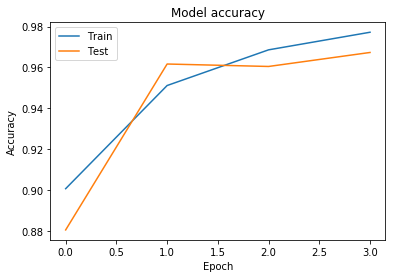

In [70]:
# Plot training & validation accuracy values 
plt.plot(history.history['acc']) 
plt.plot(history.history['val_acc']) 
plt.title('Model accuracy') 
plt.ylabel('Accuracy') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show() 

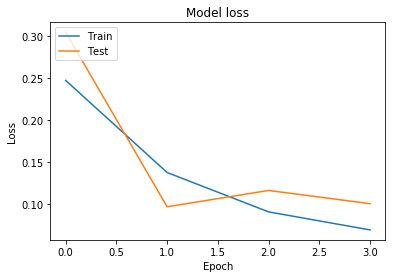

In [71]:

# Plot training & validation loss values 
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

### Legacy code

In [ ]:
output_data = []

for fold in range(nfolds):
    print("fold %u/%u" % (fold+1, nfolds))
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

    print('Build model...')
    model = build_model(max_features_num, maxlen)

    print("Train...")
    X_train, X_holdout, y_train, y_holdout = train_test_split(X_train, y_train, test_size=0.05)
    best_iter = -1
    best_auc = 0.0
    out_data = {}

    for ep in range(max_epoch):
        model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=1)

        t_probs = model.predict_proba(X_holdout)
        t_auc = sklearn.metrics.roc_auc_score(y_holdout, t_probs)

        print('Epoch %d: auc = %f (best=%f)' % (ep, t_auc, best_auc))

        if t_auc > best_auc:
            best_auc = t_auc
            best_iter = ep

            probs = model.predict_proba(X_test)

            out_data = {'y':y_test, 'probs':probs, 'epochs': ep,
                        'confusion_matrix': sklearn.metrics.confusion_matrix(y_test, probs > .5)}

            print(sklearn.metrics.confusion_matrix(y_test, probs > .5))
        else:
            # No longer improving...break and calculate statistics
            if (ep-best_iter) > 2:
                break

    output_data.append(out_data)